# Decision trees

In [0]:
import numpy as np
import pandas as pd
import pydotplus
from collections import defaultdict
from sklearn import tree
from IPython.display import Image

In [0]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1, join_axes=[dfX.index])
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [0]:
df = pd.read_csv('occupancy_data/Training_with_working_hours.csv')
df = df.drop(['Unnamed: 0','Time'], 1)

In [0]:
class_name = 'Occupancy'
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res

In [0]:
df

,Temperature,Humidity,Light,CO2,WorkingHours,Hour,Minute,WeekDay=Friday,WeekDay=Monday,WeekDay=Saturday,WeekDay=Sunday,WeekDay=Thursday,WeekDay=Tuesday,WeekDay=Wednesday,Occupancy
0,23.180000,27.272000,426.0,721.250000,1,17,51,0,0,0,0,0,0,1,1
1,23.150000,27.267500,429.5,714.000000,1,17,51,0,0,0,0,0,0,1,1
2,23.150000,27.245000,426.0,713.500000,1,17,53,0,0,0,0,0,0,1,1
3,23.150000,27.200000,426.0,708.250000,1,17,54,0,0,0,0,0,0,1,1
4,23.100000,27.200000,426.0,704.500000,1,17,55,0,0,0,0,0,0,1,1
5,23.100000,27.200000,419.0,701.000000,1,17,55,0,0,0,0,0,0,1,1
6,23.100000,27.200000,419.0,701.666667,1,17,57,0,0,0,0,0,0,1,1
7,23.100000,27.200000,419.0,699.000000,1,17,57,0,0,0,0,0,0,1,1
8,23.100000,27.200000,419.0,689.333333,1,17,58,0,0,0,0,0,0,1,1
9,23.075000,27.175000,419.0,688.000000,0,18,0,0,0,0,0,0,0,1,1


In [0]:
clf = tree.DecisionTreeClassifier()

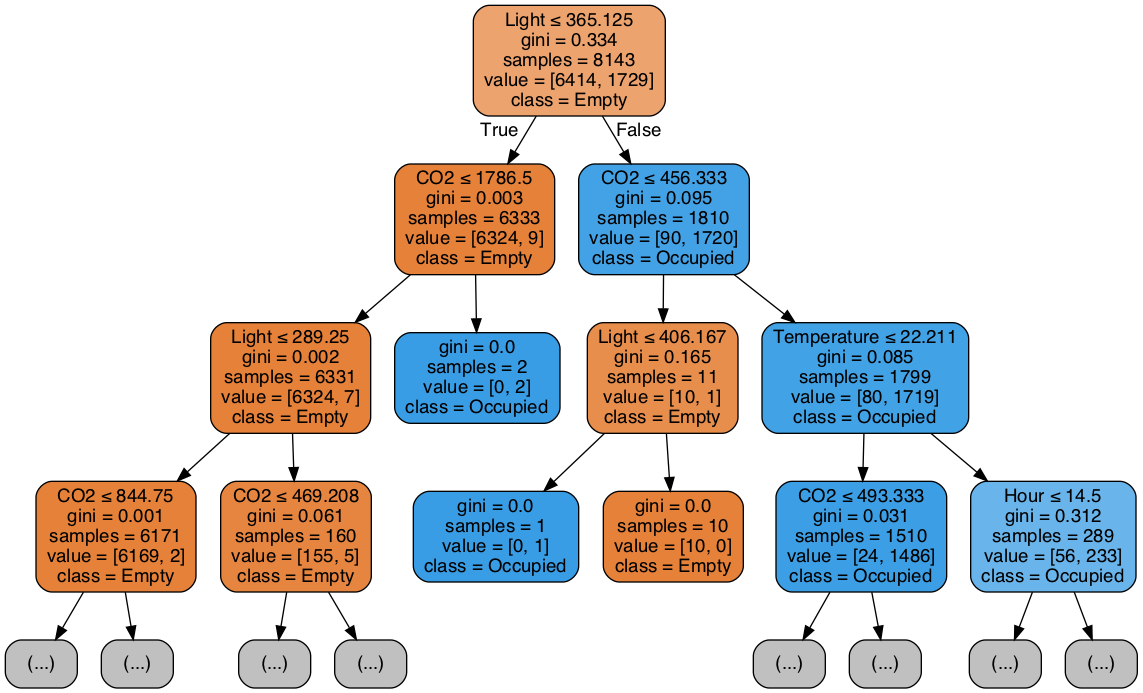

In [0]:
class_labels = df['Occupancy'].values
clf.fit(df.drop('Occupancy', 1), class_labels)

dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=df.drop('Occupancy', 1).columns,
                                class_names=['Occupied' if x == 1 else 'Empty' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [0]:
df_test = pd.read_csv('occupancy_data/Test_with_working_hours.csv')

In [0]:
df_test = df_test.drop(['Unnamed: 0', 'Time'],1)

In [0]:
res = prepare_dataset(df_test, class_name)
df_test, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res

In [0]:
df_test

,Temperature,Humidity,Light,CO2,Hour,Minute,WorkingHours,WeekDay=Monday,WeekDay=Tuesday,WeekDay=Wednesday,Occupancy
0,23.700000,26.272000,585.200000,749.200000,14,19,1,1,0,0,1
1,23.718000,26.290000,578.400000,760.400000,14,19,1,1,0,0,1
2,23.730000,26.230000,572.666667,769.666667,14,21,1,1,0,0,1
3,23.722500,26.125000,493.750000,774.750000,14,22,1,1,0,0,1
4,23.754000,26.200000,488.600000,779.000000,14,23,1,1,0,0,1
5,23.760000,26.260000,568.666667,790.000000,14,23,1,1,0,0,1
6,23.730000,26.290000,536.333333,798.000000,14,25,1,1,0,0,1
7,23.754000,26.290000,509.000000,797.000000,14,25,1,1,0,0,1
8,23.754000,26.350000,476.000000,803.200000,14,26,1,1,0,0,1
9,23.736000,26.390000,510.000000,809.000000,14,28,1,1,0,0,1


In [0]:
df_test['WeekDay=Thursday'] = 0
df_test['WeekDay=Friday'] = 0
df_test['WeekDay=Saturday'] = 0
df_test['WeekDay=Sunday'] = 0

In [0]:
y_pred_tr = clf.predict(df.drop('Occupancy',1))
y_pred_test = clf.predict(df_test.drop('Occupancy',1))

In [0]:
for col, imp in zip(df.drop('Occupancy', 1).columns, clf.feature_importances_):
    print(col, imp)

Temperature 0.010239794279674792
Humidity 0.011940803300781956
Light 0.937491675033995
CO2 0.019046582294760955
WorkingHours 0.0
Hour 0.012544523134989018
Minute 0.008729077040139081
WeekDay=Friday 0.0
WeekDay=Monday 0.0
WeekDay=Saturday 0.0
WeekDay=Sunday 0.0
WeekDay=Thursday 7.544915659217313e-06
WeekDay=Tuesday 0.0
WeekDay=Wednesday 0.0


### Analyze the classification performance

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [0]:
print('Train Accuracy %s' % accuracy_score(df['Occupancy'].values, y_pred_tr))
print('Train F1-score %s' % f1_score(df['Occupancy'].values, y_pred_tr, average=None))
print()

print('Test Accuracy %s' % accuracy_score(df_test['Occupancy'].values, y_pred_test))
print('Test F1-score %s' % f1_score(df_test['Occupancy'].values, y_pred_test, average=None))
print(classification_report(df_test['Occupancy'].values, y_pred_test))
confusion_matrix(df_test['Occupancy'].values, y_pred_test)

Train Accuracy 1.0
Train F1-score [1. 1.]

Test Accuracy 0.9523452157598499
Test F1-score [0.96261407 0.93429902]
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1693
           1       0.94      0.93      0.93       972

    accuracy                           0.95      2665
   macro avg       0.95      0.95      0.95      2665
weighted avg       0.95      0.95      0.95      2665



array([[1635,   58],
       [  69,  903]])